Apple Inc. Stock Price Prediction

Imports

In [ ]:
# Install necessary libraries
#!pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

# Import libraries
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.model_selection import TimeSeriesSplit # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import yfinance as yf # type: ignore
import matplotlib.pyplot as plt # type: ignore

Necessary functions

In [ ]:
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0).fillna(0)
    loss = -delta.where(delta < 0, 0).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_technical_indicators(data):
    # Relative Strength Index (RSI)
    data['RSI'] = calculate_RSI(data)
    
    # Simple Moving Average (SMA)
    data['SMA'] = data['Close'].rolling(window=20).mean()

    # Exponential Moving Average (EMA)
    data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()
    
    # Bollinger Bands
    data['Middle_Band'] = data['Close'].rolling(window=20).mean()
    data['Upper_Band'] = data['Middle_Band'] + 2 * data['Close'].rolling(window=20).std()
    data['Lower_Band'] = data['Middle_Band'] - 2 * data['Close'].rolling(window=20).std()
    
    # Moving Average Convergence Divergence (MACD)
    data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    data['Day_sin'] = np.sin(2 * np.pi * data.index.dayofyear / 365)
    data['Day_cos'] = np.cos(2 * np.pi * data.index.dayofyear / 365)

    
    return data

Data preprocessing

In [ ]:
data = yf.download("AAPL", start="2006-12-01", end="2016-12-01")

data = add_technical_indicators(data)

# Incorporating the external sentiment scores
scores = pd.read_csv("Scores.csv")['Scores'].to_list()
data['Score'] = scores

# Handling missing values: Forward fill and interpolate remaining gaps
data.fillna(method='backfill', inplace=True)
data.interpolate(method='linear', inplace=True)

# Selecting relevant features
features = ['Close', 'RSI', 'Score', 'Volume', 'SMA', 'EMA', 'Upper_Band', 'Lower_Band', 'MACD', 'Signal_Line', "Day_sin", "Day_cos"]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

scaled_data = scaler.fit_transform(data[features])

# Creating sequences
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0]) 
    return np.array(sequences), np.array(targets)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label=f'AAPL Closing Price')
plt.title(f'AAPL Closing Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.legend()
plt.show()

Model training

In [18]:
model = Sequential([
    Input(shape=(seq_length, X.shape[2])),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.1202 - val_loss: 0.0382
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0063 - val_loss: 0.0520
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0054 - val_loss: 0.0353
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0046 - val_loss: 0.0256
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0045 - val_loss: 0.0279
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0047 - val_loss: 0.0290
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0035 - val_loss: 0.0278
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0034 - val_loss: 0.0387
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0030 - val_loss: 0.0404
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0032 - val_loss: 0.0404
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0030 - val_loss: 0.0222
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/ste

Evaluate and predict

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0196
Mean Squared Error (MSE): 0.022163717076182365
Root Mean Squared Error (RMSE): 0.14887483694762646
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted closing stock price for tomorrow: 27.549070642524228


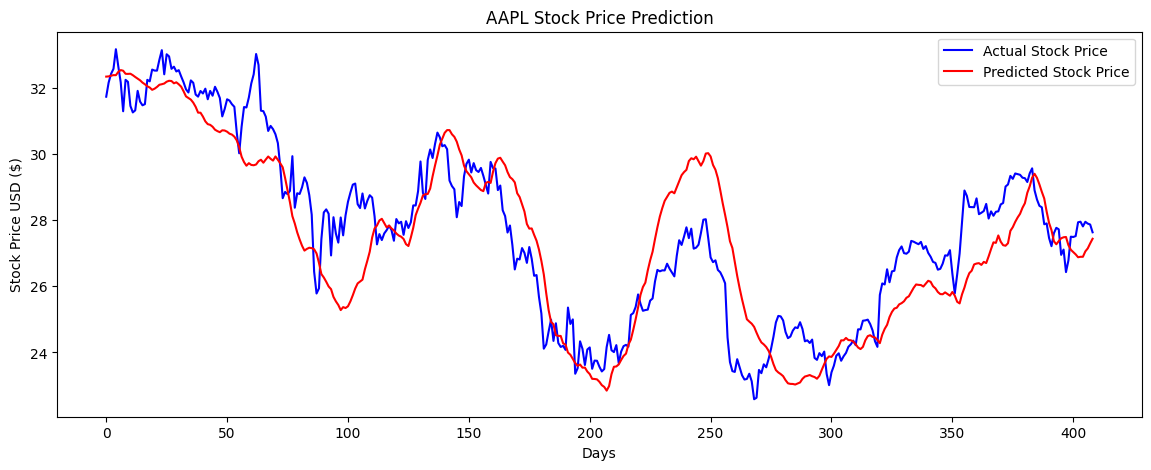

In [19]:
# Evaluate the model
mse = model.evaluate(X_test, y_test)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Make predictions
predictions = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2]-1))), axis=1))[:, 0]
predicted_prices = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X.shape[2]-1))), axis=1))[:, 0]
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, len(features)))
predicted_price_scaled = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(np.concatenate((predicted_price_scaled, np.zeros((predicted_price_scaled.shape[0], X.shape[2]-1))), axis=1))[:, 0]

print("Predicted closing stock price for tomorrow:", predicted_price[0])

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title(f'AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()